In [2]:
import torch.nn as nn
import wandb
import torch
import pickle
from datasets.dataset import SolarFlaresData
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from typing import Any
from datetime import datetime
import drms
import pandas as pd
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from transformers import (
    ViTConfig,
    ViTImageProcessor,
    ViTForImageClassification,
)

/Users/mohamedelabbas/solar-flares-forecasting/solar-flares-forecasting/solar-flares-forecasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def read_df_from_pickle(path):
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df

# Problem

We're exploring a challenge of predicting solar flares. Given the line-of-sight magnetic images (magnetograms), this task involves telling apart active regions that are about to experience a strong solar flare (either M- or X-class) in the next 24 hours (based on the input magnetogram) from regions that are expected to remain calm without any flares during the same period.







## Mathematical Description:
$$
\begin{align*}
& H_0: P(\text{flare} \geq \text{M1} | X) > \theta_0 \\
& \text{There will  be a solar flare with intensity greater than or equal to M1 in the next 24 hours based on the magnetogram image \(X\).} \\
\\
& H_1: P(\text{flare} \geq \text{M1} | X) \leq \theta_0 \\
& \text{There will be a solar flare with intensity less than  M1 in the next 24 hours based on the magnetogram image \(X\).}
\end{align*}
$$

$$
\begin{align*}
& X: \text{Feature space representing magnetogram images.} \\
& Y: \text{Set of class labels, where } Y = \{0, 1\} \text{ for a binary classification problem.} \\
& H_0: \text{Null hypothesis.} \\
& H_1: \text{Alternative hypothesis.} \\
& \theta_0: \text{Critical probability threshold under the null hypothesis.} \\
& P: \text{Predicted probability of a solar flare based on the CNN model.} \\
\end{align*}
$$


# Dataset

Our dataset can be mathematically described as follows
$$ \ \text{Dataset:} \quad \{(X_i, Y_i) \mid X_i \in \mathbb{R}^{128 \times 128}, Y_i \in \{0, 1\}\} \$$

Our dataset consists of pairs $(X_i, Y_i)$ where $X_i$ represents a 128×128 magnetogram image and $Y_i$ is either 0 or 1, indicating the absence or presence of a solar flare with intensity greater than or equal to M1 in the next 24 hours time period.

#### Magnetograms Preprocesssing

To preprocess the magnetograms we use the following approach : 

1. Check for NaN Values:

    - Examine each magnetogram for the presence of NaN (Not a Number) values.

2. Handle NaN Values:

    - If NaN values are found, decide on a strategy:
        - Exclude the magnetogram from further processing.
        
3. Apply Z-score Standardization:

    - Standardize each magnetogram using Z-score normalization.
    - Compute the mean ($\mu$) and standard deviation ($\sigma$) of the pixel values across all magnetograms.
    - For each pixel value $x$ in a magnetogram, calculate the Z-score using the formula: $$\Z = \frac{{X - \mu}}{{\sigma}}$$
    - This ensures that pixel values are centered around zero and scaled by the standard deviation.
4. Reshape the magnetogram: 
- active regions magnetograms have different sizes; that is why we need to reshape them to have similar dimensions. 
In this work,we reshape the magnetograms to 128 x 128. 
5. Output Preprocessed Magnetograms:

    The result of these preprocessing steps is a set of magnetograms ready for use in our CNN model.

The diagram below illustrates the magnetogram preprocessing steps

![alternative text](figures/magnetogram_preprocessing.png)

In [4]:
dataset = read_df_from_pickle("data/SHARP/SHARP.pkl")

Sample region before preprocessing

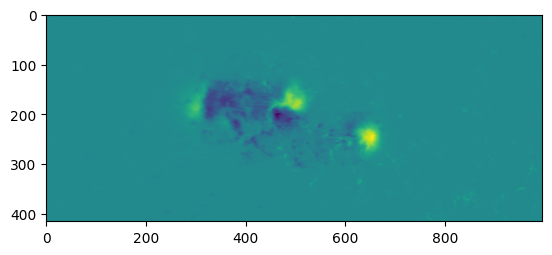

In [5]:
plt.imshow(dataset[dataset["T_REC"] == "2015-12-23 01:12:00"]["magnetogram"][0])
plt.show()

Sample region after preprocessing 

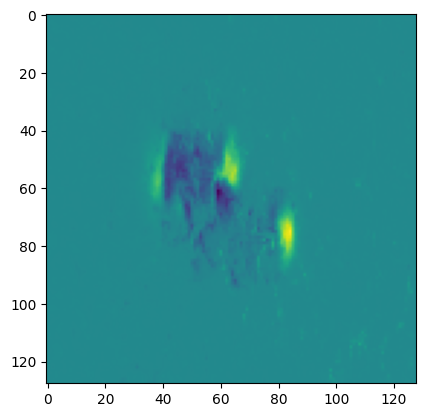

In [6]:
transform = T.Resize((128, 128))
magnetogram = dataset[dataset["T_REC"] == "2015-12-23 01:12:00"]["magnetogram"][0]
# print(magnetogram.shape)
resized_magnetogram = transform(torch.from_numpy(magnetogram).unsqueeze(0))

plt.imshow(resized_magnetogram.squeeze(0))
plt.show()

#### Labelling Process

1. Initialize Parameters:
- Set the observation period duration to 24 hours.
- Set the prediction period duration to the 24 hours following the observation period.
- Define the step size for sliding the time window as 96 minutes.

2. Extract Samples:
- Start with the initial 24-hour time window.
- Slide the time window through the active region sequence with a step size of 96 minutes.
- Extract samples from each 24-hour subsequence.

3. Label Samples:

- For each extracted sample:

    - If the sample exhibits an M- or X-class flare in the prediction period, assign it to the positive class.
    
    - If the sample has no flare of any class in both the observation and prediction periods, assign it to the negative class.
4. Repeat:
- Continue sliding the time window with the defined step size until the entire active region sequence is covered.

To get the labels given the SHARP/SMARP dataset magnetograms and the NOAA GOES flare intensity dataset, we use the following approach:

Below is a part of the dataset after the labelling process :

In [7]:
dataset.head()

,T_REC,region_type,region_no,NOAA_ARS,params,magnetogram,label
0,2015-12-23 01:12:00,harp,6206,12473,"[-0.0100475028260637, 1.2602700352173024, 0.99...","[[-0.06619508896585617, -0.05401688210435899, ...",1
1,2015-12-23 02:48:00,harp,6206,12473,"[0.066513399626304, 1.2994691822566444, 1.0664...","[[-0.22045237587815394, -0.204214766729491, -0...",1
2,2015-12-23 04:24:00,harp,6206,12473,"[0.1669003090659236, 1.328868542536151, 1.1183...","[[-0.032705020096738896, -0.041838675242861785...",1
3,2015-12-23 06:00:00,harp,6206,12473,"[0.2331366084904823, 1.2643052415301756, 1.161...","[[-0.08040299697093622, -0.043868376386444655,...",1
4,2015-12-23 07:36:00,harp,6206,12473,"[0.2683990988316146, 1.29255168572029, 1.14740...","[[-0.10881881298109633, -0.13013067498871642, ...",1


In [8]:
df.region_no.unique()

NameError: name 'df' is not defined

In [34]:
class SolarFlaresData(Dataset):
    def __init__(self, df, random_undersample=True, resize=128):
        self.resize_transform = T.Resize((resize, resize))
        self.df = self.random_undersample(df) if random_undersample else df

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.df.loc[idx, "params"]).to(torch.float32),
            self.resize_transform(
                torch.from_numpy(self.df.loc[idx, "magnetogram"])
                .unsqueeze(0)
                .to(torch.float32)
            ),
            torch.tensor(self.df.loc[idx, "label"]),
        )

    def random_undersample(self, df):
        positive_samples_count = len(df[df.label == 1])
        negative_samples_count = len(df[df.label == 0])
        samples_dropped_count = negative_samples_count - positive_samples_count
        indices_to_drop = np.random.choice(
            df[df.label == 0].index, samples_dropped_count, replace=False
        )
        df_dropped = df.drop(indices_to_drop)
        return df_dropped.reset_index()

    def __len__(self):
        return self.df.shape[0]

## Model : CNN

![alternative text](figures/cnn_archdrawio.png)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.ModuleList(
            [cnn_block(11, 1), cnn_block(11, 64)]
            + [cnn_block(3, 64), cnn_block(3, 64), cnn_block(3, 64)]
        )
        self.linear = nn.Linear(64, 128)
        self.bn = nn.BatchNorm1d(128)
        self.drop_out = nn.Dropout(0.5)
        self.linear2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop_out2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 2)

    def forward(self, x):
        for idx, l in enumerate(self.cnn):
            x = l(x)
        # print(x.shape)
        x = x.squeeze(2).squeeze(2).reshape(-1, 64)
        x = self.linear(x)
        # print(x.shape)
        x = self.bn(x)
        # print(x.shape)
        x = self.drop_out(x)
        # print(x.shape)
        x = self.linear2(x)
        # print(x.shape)
        x = self.bn2(x)
        # print(x.shape)
        x = self.drop_out2(x)
        # print(x.shape)
        x = self.linear3(x)
        return x


class cnn_block(nn.Module):
    def __init__(self, filter_size, in_channels):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels=in_channels, out_channels=64, kernel_size=filter_size
        )
        self.bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.cnn(x)
        x = self.bn(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        return x


class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=4, hidden_size=64, num_layers=2, batch_first=True
        )

    def forward(self, x):
        return self.lstm(x)

# Model: CNN With Self Attention

Convolutional Neural Networks (CNNs) are powerful tools in image analysis. When applied to predicting solar flares from magnetogram images, they shine because they're adept at automatically learning and recognizing complex patterns in the images. The spatial structures and hierarchies in magnetogram images align well with CNNs, making them an excellent choice for detecting subtle features that may indicate impending solar flare activity. The CNN model is employed on the line-of-sight magnetogram. The optimization process is facilitated by the Adam optimizer, which seeks to minimize a binary cross-entropy loss function. Focal Loss is also experimented.

In [11]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttentionLayer, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = (
            self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)
        )
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height)

        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        out = self.gamma * out + x
        return out

In [12]:
class CNNWithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.ModuleList(
            [cnn_block(11, 1), cnn_block(11, 64)]
            + [cnn_block(3, 64), cnn_block(3, 64), cnn_block(3, 64)]
        )
        self.self_attention = SelfAttentionLayer(64)
        self.linear = nn.Linear(64, 128)
        self.bn = nn.BatchNorm1d(128)
        self.drop_out = nn.Dropout(0.5)
        self.linear2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop_out2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 2)

    def forward(self, x):
        for idx, l in enumerate(self.cnn):
            x = l(x)
        # print(x.shape)
        x = self.self_attention(x)
        x = x.squeeze(2).squeeze(2).reshape(-1, 64)
        x = self.linear(x)
        # print(x.shape)
        x = self.bn(x)
        # print(x.shape)
        x = self.drop_out(x)
        # print(x.shape)
        x = self.linear2(x)
        # print(x.shape)
        x = self.bn2(x)
        # print(x.shape)
        x = self.drop_out2(x)
        # print(x.shape)
        # x = self.self_attention(x)
        x = self.linear3(x)
        return x


class cnn_block(nn.Module):
    def __init__(self, filter_size, in_channels):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels=in_channels, out_channels=64, kernel_size=filter_size
        )
        self.bn = nn.BatchNorm2d(64)
        # self.self_attention = SelfAttentionLayer(64)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.cnn(x)
        x = self.bn(x)
        x = nn.functional.relu(x)
        # x = self.self_attention(x)
        x = self.pool(x)
        return x


class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=4, hidden_size=64, num_layers=2, batch_first=True
        )

    def forward(self, x):
        return self.lstm(x)


## Model: Vision Transformer

![alternative text](figures/vit_1.png)

In [13]:
class ViT(nn.Module):
    def __init__(self):
        super().__init__()
        config = ViTConfig(num_channels=1)
        self.image_processor = ViTImageProcessor(
            do_normalize=False, do_rescale=False, do_resize=False
        )
        self.vit = ViTForImageClassification(config)

    def forward(self, x):
        model_inputs = self.image_processor(x, return_tensors="pt")
        outputs = self.vit(**model_inputs)
        return outputs.logits

In [73]:
ViT()

ViT(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0): ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTInt

# Training

Two loss functions are tried: Focal Loss and Binary Cross Entropy Loss. Focal Loss is used  because it's adept at handling the challenge of imbalanced data, especially evident in the solar flares dataset where strong flares are rare. This choice allows  to pay special attention to and accurately address these infrequent but significant events.

**Binary Cross-Entropy Loss**   


$$\text{BCE}(y_i, p_i) = y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i)$$


In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        focal_loss = (1 - torch.exp(-ce_loss)) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return torch.mean(focal_loss)
        elif self.reduction == "sum":
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [15]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
    disp.plot()
    plt.show()

In [58]:
def read_df_from_pickle(path):
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df


def compute_accuracy(predictions, correct):
    return (predictions == correct).sum().item() / predictions.shape[0]


def confusion(prediction, target):
    confusion_vector = prediction / target
    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float("inf")).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives


def compute_tss(prediction, target):
    TP, FP, TN, FN = confusion(prediction, target)
    # print(TP, FP, TN, FN)
    N = TN + FP
    P = TP + FN
    return TP / P - FP / N


def region_based_split(dataset_df, train_regions, test_regions):
    train_df = dataset_df[dataset_df.region_no.isin(set(train_regions))]
    test_df = dataset_df[dataset_df.region_no.isin(set(test_regions))]
    return train_df, test_df


# Hyperparameters
lr = 0.001
batch_size = 16
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
df = read_df_from_pickle("data/SHARP/SHARP.pkl")
train_df, test_df = region_based_split(
    # 6206, 10, 7169, 4097, 6327, 1, 2
    df,
    train_regions=[1, 6206, 4097],
    test_regions=[2, 6327, 7169],
)
print(f"regions in train set {train_df.region_no.unique()}")
print(f"regions in validation set{test_df.region_no.unique()}")

train_dataset = SolarFlaresData(
    train_df.reset_index(), random_undersample=False, resize=128
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SolarFlaresData(
    test_df.reset_index(), random_undersample=False, resize=128
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

regions in train set [6206 4097 1]
regions in validation set[7169 6327 2]


In [59]:
def train(num_epochs, model, optimizer, criterion):
    train_losses = []
    val_losses = []
    accuracies = []
    tss_scores = []
    for epoch in range(1, num_epochs):
        epoch_train_losses = []
        model.train()
        with tqdm(train_loader, unit="batch") as tepoch:
            for _, data, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")

                data, target = data.to(device), target.to(device)
                logits = model(data)
                predictions = logits.argmax(dim=1, keepdim=True).squeeze()
                loss = criterion(logits, target)
                loss.backward()
                optimizer.step()
                epoch_train_losses.append(loss.item())
                # acc = compute_accuracy(predictions, target)
                # tss = compute_tss(acc)
                tepoch.set_postfix(loss=loss.item())

        model.eval()
        with torch.no_grad():
            with tqdm(test_loader, unit="batch") as tepoch:
                batch_correct = []
                batch_tss = []
                batch_valid_losses = []
                all_predictions = []
                all_targets = []
                for _, data, target in tepoch:
                    tepoch.set_description(f"Epoch {epoch}")
                    data, target = data.to(device), target.to(device)
                    logits = model(data)
                    predictions = logits.argmax(dim=1, keepdim=True).squeeze()
                    all_predictions.append(predictions)
                    all_targets.append(target)
                    loss = criterion(logits, target)
                    batch_valid_losses.append(loss.item())
                    correct = (predictions == target).sum().item()
                    batch_acc = compute_accuracy(predictions, target)
                    batch_correct.append(correct)

                    tepoch.set_postfix(
                        valid_loss=loss.item(),
                    )
        train_losses.append(np.mean(epoch_train_losses))
        val_losses.append(np.mean(batch_valid_losses))
        accuracies.append(np.sum(batch_correct) / len(test_dataset))
        all_predictions = torch.cat(all_predictions, axis=0)
        all_targets = torch.cat(all_targets, axis=0)
        # print(all_targets.shape, all_predictions.shape)
        tss_scores.append(compute_tss(all_predictions, all_targets))
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(len(accuracies)), accuracies, label="Accuracy", color="blue")
    plt.plot(range(len(tss_scores)), tss_scores, label="TSS Score", color="green")
    plt.title("Accuracy and TSS Score")
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(len(train_losses)), train_losses, label="Training Loss", color="red")
    plt.plot(
        range(len(val_losses)), val_losses, label="Validation Loss", color="purple"
    )
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Experiment summary")
    print(f"Number of epochs {num_epochs}")
    print(f"batch size {batch_size}")
    print(
        f"train set length {len(train_df)} with {len(train_df[train_df.label == 1])} positive examples and {len(train_df[train_df.label == 0])} negative examples"
    )

    print(
        f"test set length {len(test_df)} with {len(test_df[test_df.label == 1])} positive examples and {len(test_df[test_df.label == 0])} negative examples"
    )
    print(f"max accuracy {max(accuracies)}")
    print(f"max tss score {max(tss_scores)}")

    return train_losses, val_losses, accuracies, tss_scores

In [60]:
def predict(test_loader, model):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            for _, data, target in tepoch:
                data, target = data.to(device), target.to(device)
                logits = model(data)
                predictions = logits.argmax(dim=1, keepdim=True).squeeze()
                all_predictions.extend(predictions.tolist())
                all_targets.extend(target.tolist())
    return all_predictions, all_targets

# Train : CNN

In [61]:
cnn_model = CNN()
optimizer = Adam(cnn_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Epoch 19: 100%|██████████| 16/16 [00:05<00:00,  3.20batch/s, valid_loss=0.278]


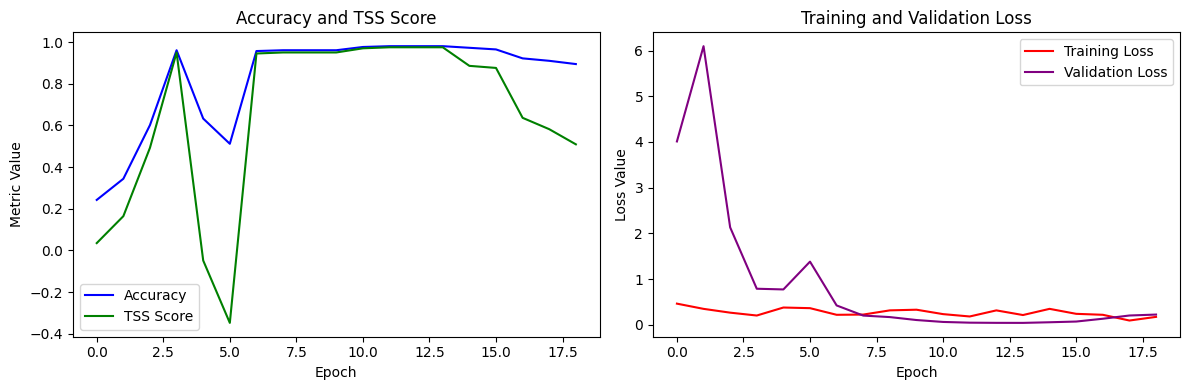

Experiment summary
Number of epochs 20
batch size 16
train set length 172 with 39 positive examples and 133 negative examples
test set length 256 with 55 positive examples and 201 negative examples
max accuracy 0.98046875
max tss score 0.9751243781094527


In [62]:
cnn_train_loss, cnn_val_loss, cnn_acc, cnn_tss = train(
    num_epochs, cnn_model, optimizer, criterion
)

# Inference : CNN 

To make predictions, we take a threshold $\theta_0 = 0.5 $  

100%|██████████| 16/16 [00:04<00:00,  3.24batch/s]


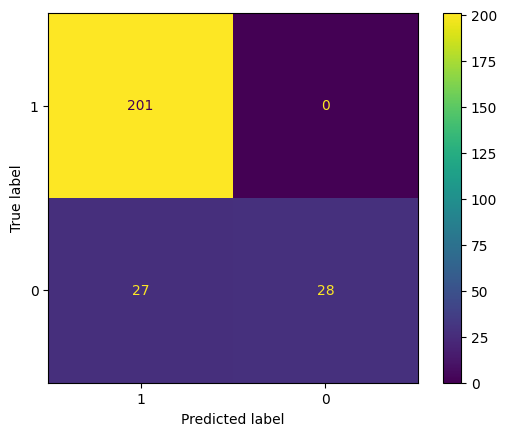

In [63]:
cnn_predictions, cnn_targets = predict(test_loader, cnn_model)
plot_confusion_matrix(cnn_targets, cnn_predictions)

## Train : CNN With Attention

In [64]:
cnn_with_att_model = CNNWithAttention()
optimizer = Adam(cnn_with_att_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Epoch 19: 100%|██████████| 16/16 [00:05<00:00,  2.88batch/s, valid_loss=0.0187]


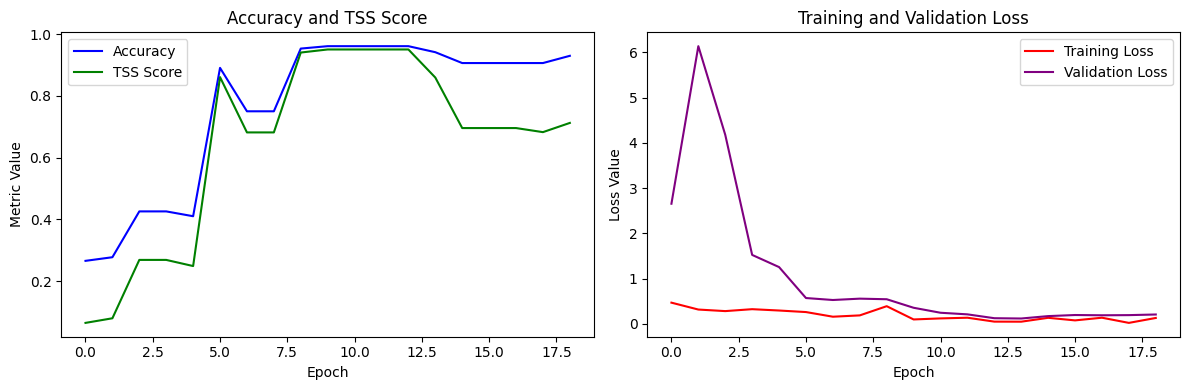

Experiment summary
Number of epochs 20
batch size 16
train set length 172 with 39 positive examples and 133 negative examples
test set length 256 with 55 positive examples and 201 negative examples
max accuracy 0.9609375
max tss score 0.9502487562189055


In [65]:
(
    cnn_with_att_train_loss,
    cnn_with_att_val_loss,
    cnn_with_att_acc,
    cnn_with_att_tss,
) = train(num_epochs, cnn_with_att_model, optimizer, criterion)

## Inference : CNN With Attention

100%|██████████| 16/16 [00:05<00:00,  3.07batch/s]


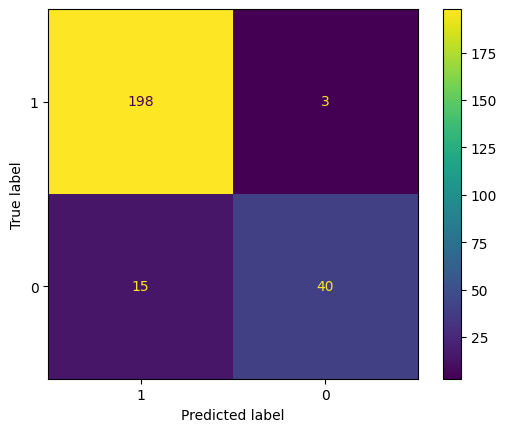

In [66]:
cnn_with_att_predictions, cnn_with_att_targets = predict(
    test_loader, cnn_with_att_model
)
plot_confusion_matrix(cnn_with_att_targets, cnn_with_att_predictions)

## Train : Vision Transformer

In [39]:
model = ViT()
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Epoch 19: 100%|██████████| 16/16 [00:20<00:00,  1.25s/batch, valid_loss=23.6]


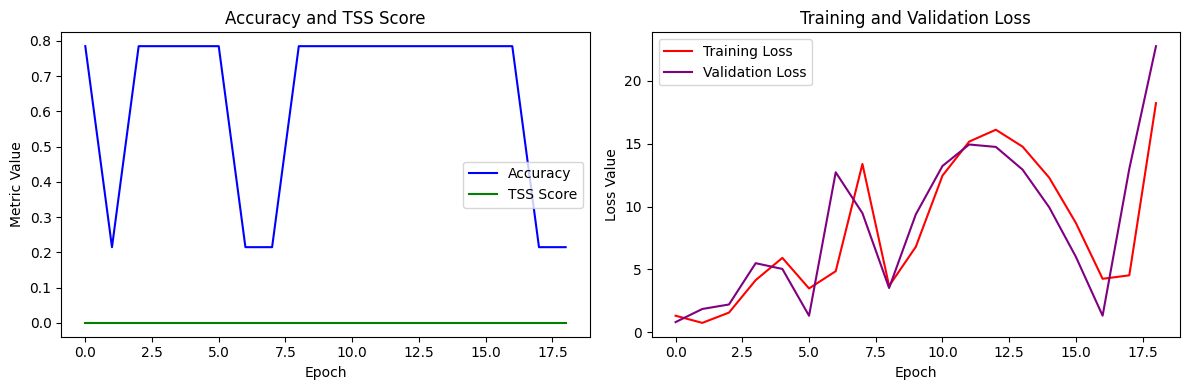

Experiment summary
Number of epochs 20
batch size 16
train set length 172 with 39 positive examples and 133 negative examples
test set length 256 with 55 positive examples and 201 negative examples
max accuracy 0.78515625
max tss score 0.0


In [43]:
(
    vit_train_loss,
    vit_val_loss,
    vit_acc,
    vit_tss,
) = train(num_epochs, model, optimizer, criterion)

## Inference : Vision Transformer

100%|██████████| 16/16 [00:20<00:00,  1.28s/batch]


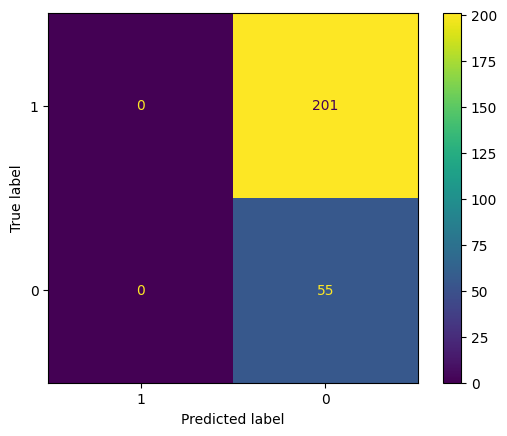

In [51]:
vit_predictions, vit_targets = predict(test_loader, model)
plot_confusion_matrix(vit_targets, vit_predictions)

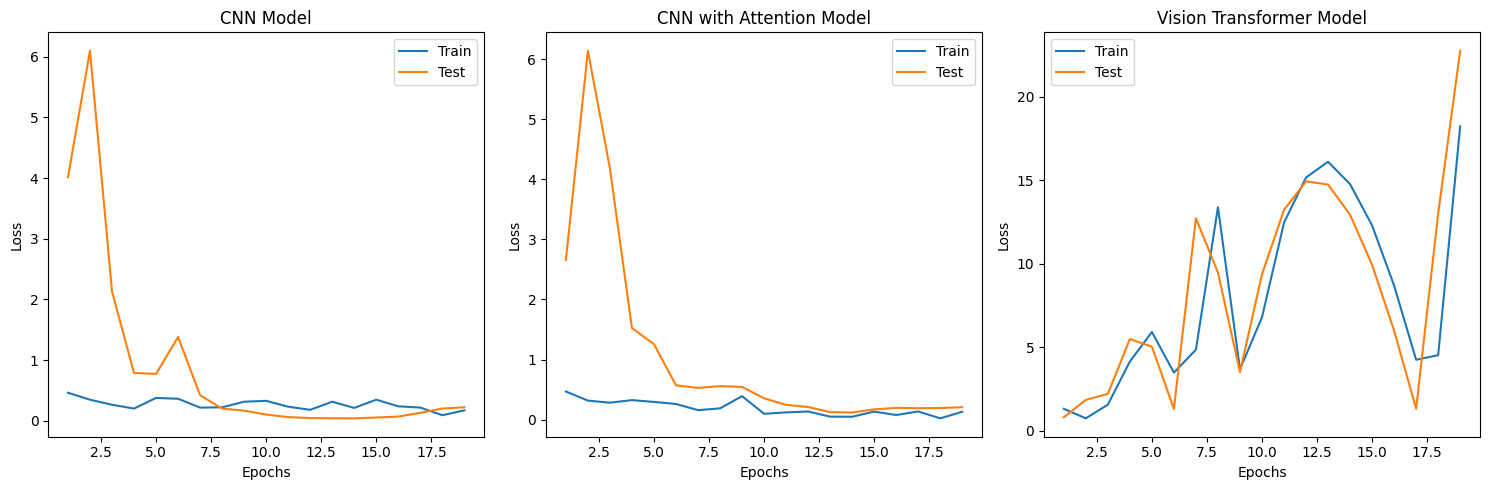

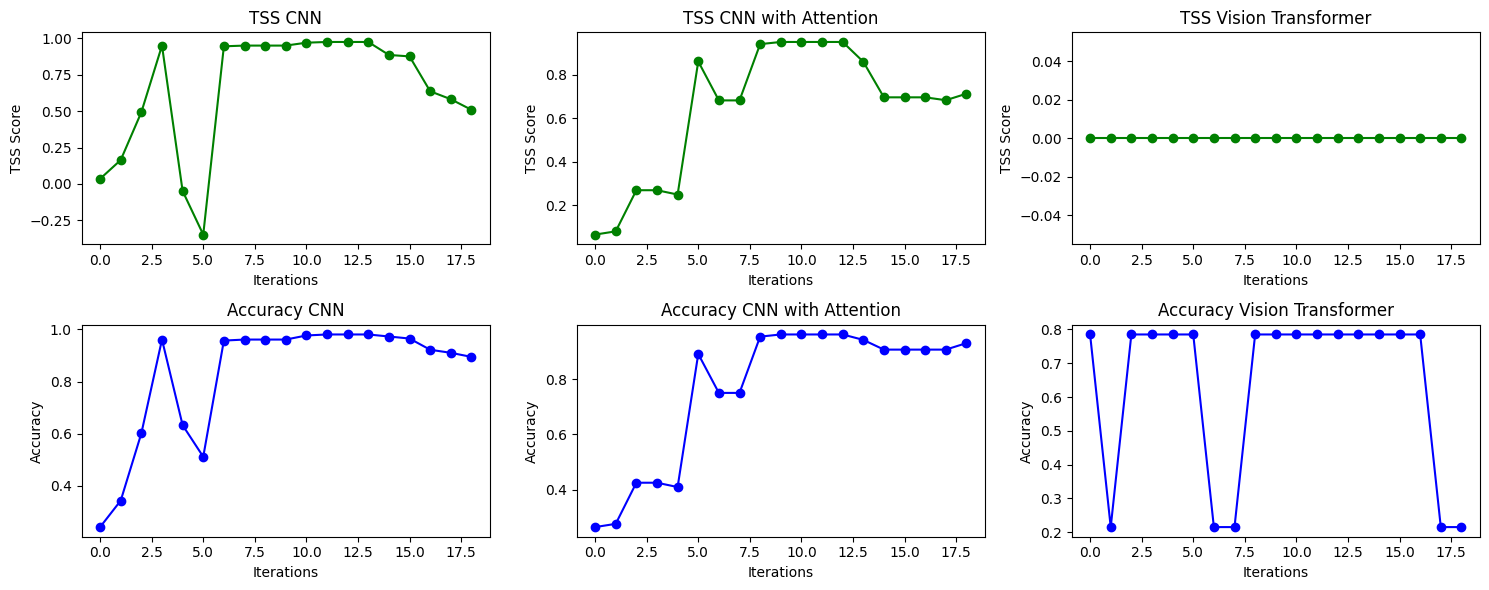

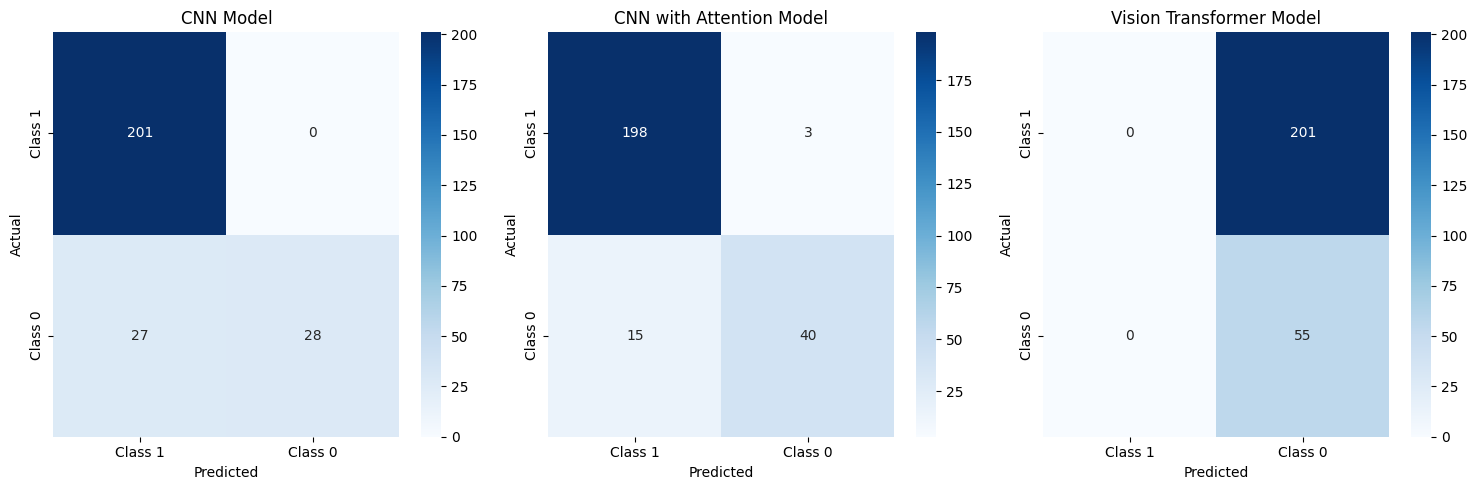

In [77]:
import matplotlib.pyplot as plt


epochs = list(range(1, 20))

# Plotting
plt.figure(figsize=(15, 5))

# CNN Plot
plt.subplot(1, 3, 1)
plt.plot(epochs, cnn_train_loss, label="Train")
plt.plot(epochs, cnn_val_loss, label="Test")
plt.title("CNN Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# CNN with Attention Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, cnn_with_att_train_loss, label="Train")
plt.plot(epochs, cnn_with_att_val_loss, label="Test")
plt.title("CNN with Attention Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Vision Transformer Plot
plt.subplot(1, 3, 3)
plt.plot(epochs, vit_train_loss, label="Train")
plt.plot(epochs, vit_val_loss, label="Test")
plt.title("Vision Transformer Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt
import numpy as np

# Example TSS scores and accuracies for each model (replace these with your actual data)
models = ["CNN", "CNN with Attention", "Vision Transformer"]
tss_scores = [cnn_tss, cnn_with_att_tss, vit_tss]
accuracies = [cnn_acc, cnn_with_att_acc, vit_acc]

# Number of models
num_models = len(models)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=num_models, figsize=(15, 6))

# Plot TSS scores
for i in range(num_models):
    axes[0, i].plot(tss_scores[i], marker="o", color="green")  # Green for TSS scores
    axes[0, i].set_title(f"TSS {models[i]}")
    axes[0, i].set_xlabel("Iterations")
    axes[0, i].set_ylabel("TSS Score")

# Plot accuracies
for i in range(num_models):
    axes[1, i].plot(accuracies[i], marker="o", color="blue")  # Blue for accuracies
    axes[1, i].set_title(f"Accuracy {models[i]}")
    axes[1, i].set_xlabel("Iterations")
    axes[1, i].set_ylabel("Accuracy")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Calculate confusion matrices
cnn_conf_matrix = confusion_matrix(cnn_targets, cnn_predictions)
cnn_attention_conf_matrix = confusion_matrix(
    cnn_with_att_targets, cnn_with_att_predictions
)
vit_conf_matrix = confusion_matrix(vit_targets, vit_predictions)

# Plotting
labels = ["Class 1", "Class 0"]
plt.figure(figsize=(15, 5))

# CNN Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(
    cnn_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.title("CNN Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# CNN with Attention Confusion Matrix
plt.subplot(1, 3, 2)
sns.heatmap(
    cnn_attention_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.title("CNN with Attention Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Vision Transformer Confusion Matrix
plt.subplot(1, 3, 3)
sns.heatmap(
    vit_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.title("Vision Transformer Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()